In [133]:
import pandas as pd

In [134]:
df = pd.read_csv("SemArt/semart_train.csv", sep="	", encoding="unicode_escape")
df.columns = df.columns.str.lower()

In [135]:
len(df["timeframe"].unique())

22

In [136]:
df.columns

Index(['image_file', 'description', 'author', 'title', 'technique', 'date',
       'type', 'school', 'timeframe'],
      dtype='object')

In [137]:
df.groupby("timeframe").size()

timeframe
0751-0800       2
0801-0850       5
0851-0900       3
0951-1000       4
1001-1050       1
1051-1100      26
1101-1150      14
1151-1200      21
1201-1250      29
1251-1300     116
1301-1350     670
1351-1400     347
1401-1450     938
1451-1500    2059
1501-1550    2576
1551-1600    1582
1601-1650    3404
1651-1700    2088
1701-1750    1444
1751-1800    1114
1801-1850    1056
1851-1900    1745
dtype: int64

In [138]:
df.groupby("school").size().sort_values()

school
Finnish             5
Portuguese          5
Polish             16
Norwegian          18
Irish              21
Other              22
Swedish            23
Bohemian           29
Catalan            35
Greek              37
Belgian            45
Scottish           46
Russian            68
Swiss              89
Danish             94
American          113
Hungarian         178
Austrian          216
Netherlandish     217
English           411
Spanish           852
German           1173
Flemish          2016
French           2556
Dutch            2948
Italian          8011
dtype: int64

In [139]:
technique_df = df.groupby("technique").size().to_frame()

CNN

In [140]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class CNN(nn.Module):
    def __init__(self, output_dim: int):
        super(CNN, self).__init__()
        self.output_dim = output_dim
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.resnet.requires_grad_(False)
        self.sequential = nn.Sequential(
            nn.Linear(1000, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
        )

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        x = self.resnet(x)
        x = self.sequential(x)
        return x


Using device: cuda


In [141]:
from enum import Enum
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image


class DataSetEnum(Enum):
    TRAIN = "train"
    TEST = "test"
    VALIDATION = "val"


class OutputEnum(Enum):
    TIMEFRAME = "timeframe"
    SCHOOL = "school"


timeframe_encoder = {
    "0801-0850": 0,
    "0851-0900": 0,
    "0751-0800": 0,
    "0951-1000": 0,
    "1001-1050": 0,
    "1051-1100": 0,
    "1101-1150": 0,
    "1151-1200": 0,
    "1201-1250": 0,
    "1251-1300": 0,
    "1301-1350": 0,
    "1351-1400": 0,
    "1401-1450": 1,
    "1451-1500": 2,
    "1501-1550": 3,
    "1551-1600": 4,
    "1601-1650": 5,
    "1651-1700": 6,
    "1701-1750": 7,
    "1751-1800": 8,
    "1801-1850": 9,
    "1851-1900": 10,
}

school_encoder = {
    "Finnish": 0,
    "Portuguese": 0,
    "Polish": 0,
    "Norwegian": 0,
    "Irish": 0,
    "Other": 0,
    "Swedish": 0,
    "Bohemian": 0,
    "Catalan": 0,
    "Greek": 0,
    "Belgian": 0,
    "Scottish": 0,
    "Russian": 0,
    "Swiss": 0,
    "Danish": 0,
    "American": 0,
    "Hungarian": 0,
    "Austrian": 0,
    "Netherlandish": 0,
    "English": 0,
    "Spanish": 1,
    "German": 2,
    "Flemish": 3,
    "French": 4,
    "Dutch": 5,
    "Italian": 6,
}


class ImageDataset(Dataset):
    def __init__(self, data_set: DataSetEnum, output: OutputEnum):
        self.data_set = data_set
        self.output = output
        self.data = pd.read_csv(
            f"SemArt/semart_{data_set.value}.csv", sep="	", encoding="unicode_escape"
        )
        self.data.columns = self.data.columns.str.lower()
        self._base_path = Path() / "SemArt" / "Images"
        self.transform = transforms.Compose(
            [
                # Get the values from here: https://pytorch.org/vision/0.18/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
                transforms.Resize(232),
                # Data augmentation, randomly crop the image and flip it horizontally
                # only for the training set
                transforms.RandomCrop(224)
                if data_set == DataSetEnum.TRAIN
                else transforms.CenterCrop(224),
                transforms.RandomHorizontalFlip()
                if data_set == DataSetEnum.TRAIN
                else transforms.Lambda(lambda x: x),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.encoder = (
            timeframe_encoder
            if output == OutputEnum.TIMEFRAME
            else school_encoder
            if output == OutputEnum.SCHOOL
            else None
        )
        assert self.encoder is not None, "Invalid output type"
        self._output_dim = len(set(self.encoder.values()))

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        # Set label
        label = -1
        match self.output:
            case OutputEnum.TIMEFRAME:
                label = timeframe_encoder[self.data["timeframe"][idx]]
            case OutputEnum.SCHOOL:
                label = school_encoder[self.data["school"][idx]]

        assert label >= 0, "No label found, invalid output type"

        label_tensor = np.zeros(self._output_dim)
        label_tensor[label] = 1
        label_tensor = torch.tensor(label_tensor, dtype=torch.float32, device=device)

        # load image
        raw_image = Image.open(
            str((self._base_path / str(self.data["image_file"][idx])).resolve())
        ).convert("RGB")
        image: torch.Tensor = self.transform(raw_image)  # type: ignore
        image = image.to(device)
        return image, label_tensor


In [142]:
def get_weights_for_balanced_sampler(dataset: ImageDataset) -> np.ndarray:
    output_dim = dataset._output_dim
    class_sizes = np.zeros(output_dim)
    encoder = dataset.encoder
    assert encoder is not None
    for key, val in encoder.items():
        class_sizes[val] += len(dataset.data[dataset.data[dataset.output.value] == key])

    weights = np.zeros(len(dataset))
    for idx, row in enumerate(dataset.data.iterrows()):
        weights[idx] = len(dataset) / class_sizes[encoder[row[1][dataset.output.value]]]

    return weights


train_dataset = ImageDataset(DataSetEnum.TRAIN, OutputEnum.TIMEFRAME)
weights = get_weights_for_balanced_sampler(train_dataset)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=WeightedRandomSampler(weights, len(weights)),
)
test_dataset = ImageDataset(DataSetEnum.TEST, OutputEnum.TIMEFRAME)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [143]:
from torch.utils.tensorboard.writer import SummaryWriter

writer = SummaryWriter()

In [144]:
model = CNN(len(set(timeframe_encoder.values())))
model.to(device)
criterion = nn.CrossEntropyLoss()
criterion.to(device)
resnet_params = list(map(id, model.resnet.parameters()))
params = filter(lambda p: id(p) not in resnet_params, model.parameters())
optimizer = torch.optim.Adam(params, lr=1e-2)
print(model)

CNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [145]:
import torch.nn.functional as F
import matplotlib.pyplot as plt


def plot_class_prediction(net, images, labels):
    preds = net(images)
    probs = F.softmax(preds, dim=1)
    fig = plt.figure(figsize=(6, 6))
    labels = labels.cpu().numpy()
    images = images.cpu()
    probs = probs.cpu().detach().numpy()
    for idx in np.arange(6):
        ax = fig.add_subplot(2, 3, idx + 1, xticks=[], yticks=[])
        image = images[idx].numpy().transpose(1, 2, 0)
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image)
        ax.set_title(
            f"{labels[idx]} -> {probs[idx].argmax()}({probs[idx].max():.2f})",
            color=("green" if probs[idx].argmax() == labels[idx] else "red"),
        )
    return fig

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm


# TRAIN
def train(model, train_dataloader, criterion, optimizer, writer, epoch):
    size = len(train_dataloader)
    model.train()
    try:
        for batch, (images, labels) in tqdm(
            enumerate(train_dataloader),
            total=size,
            leave=False,
            desc=f"Training {epoch + 1}",
            position=1,
        ):
            pred = model(images)
            loss = criterion(pred, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if batch % 10 == 0:
                # accuracy
                accuracy = (pred.argmax(1) == labels.argmax(1)).sum().item() / len(
                    labels
                )
                writer.add_scalars(
                    "Train/Loss", {"train": loss.item()}, batch + size * epoch
                )
                writer.add_scalars(
                    "Train/Accuracy", {"train": accuracy}, batch + size * epoch
                )
                print(
                    f"{batch}/{size} - train loss: {loss.item():.4f} - train accuracy: {accuracy:.4f}"
                )

    except KeyboardInterrupt:
        print("Training interrupted")
        torch.save(model.state_dict(), "model.pth")
        raise KeyboardInterrupt


# TEST
def test(model, test_dataloader, criterion, writer, epoch):
    size = len(test_dataloader)
    model.eval()
    with torch.no_grad():
        confusion_matrix = np.zeros(
            (test_dataloader.dataset._output_dim, test_dataloader.dataset._output_dim)
        )
        random_index = np.random.randint(0, size)
        for batch, (images, labels) in tqdm(
            enumerate(test_dataloader),
            total=size,
            leave=False,
            desc=f"Testing {epoch + 1}",
            position=1,
        ):
            pred = model(images)
            loss = criterion(pred, labels)
            accuracy = (pred.argmax(1) == labels.argmax(1)).sum().item() / len(labels)
            writer.add_scalars("Test/Loss", {"test": loss.item()}, batch + size * epoch)
            writer.add_scalars(
                "Test/Accuracy", {"test": accuracy}, batch + size * epoch
            )
            print(
                f"{batch}/{size} - test loss: {loss.item():.4f} - test accuracy: {accuracy:.4f}"
            )

            # confusion matrix
            for idx, (p, l) in enumerate(zip(pred.argmax(1), labels.argmax(1))):
                confusion_matrix[l.item(), p.item()] += 1
                
            if batch == random_index:
                writer.add_figure(
                    "Class Prediction",
                    plot_class_prediction(model, images, labels.argmax(1)),
                    epoch,
                    close=True,
                )

        # plot confusion matrix
        fig = plt.figure()
        plt.imshow(confusion_matrix, cmap="viridis")
        plt.colorbar()
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        writer.add_figure("Confusion Matrix", fig, epoch, close=True)


epochs = 10
for epoch in tqdm(range(epochs), desc="Epochs", leave=True, total=epochs, position=0):
    clear_output(wait=True)
    train(model, train_dataloader, criterion, optimizer, writer, epoch)
    clear_output(wait=True)
    test(model, test_dataloader, criterion, writer, epoch)

# Save the model
torch.save(model.state_dict(), "model_trained.pth")


Training 3:   0%|          | 0/602 [00:00<?, ?it/s]

0/602 - train loss: 1.8517 - train accuracy: 0.3750
10/602 - train loss: 1.7560 - train accuracy: 0.3750
20/602 - train loss: 1.8417 - train accuracy: 0.3125
30/602 - train loss: 1.8978 - train accuracy: 0.3438
40/602 - train loss: 1.6907 - train accuracy: 0.4375
50/602 - train loss: 1.9225 - train accuracy: 0.3125
60/602 - train loss: 1.9933 - train accuracy: 0.3125
70/602 - train loss: 1.8267 - train accuracy: 0.2500
80/602 - train loss: 1.8470 - train accuracy: 0.3438
90/602 - train loss: 1.7930 - train accuracy: 0.3438
100/602 - train loss: 1.6853 - train accuracy: 0.3438
110/602 - train loss: 1.8910 - train accuracy: 0.2812
120/602 - train loss: 2.2521 - train accuracy: 0.1875
130/602 - train loss: 1.5072 - train accuracy: 0.5312
140/602 - train loss: 1.5753 - train accuracy: 0.4062
150/602 - train loss: 1.8345 - train accuracy: 0.4062
160/602 - train loss: 1.6261 - train accuracy: 0.3125
170/602 - train loss: 1.7066 - train accuracy: 0.3125
180/602 - train loss: 1.7604 - train ac

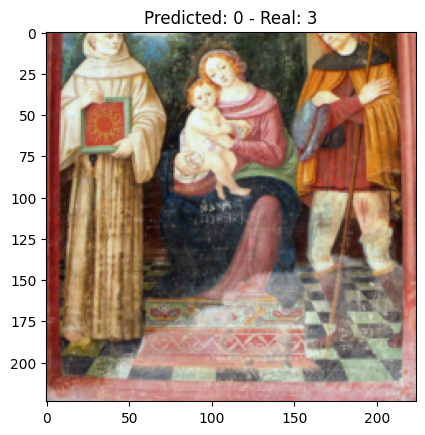

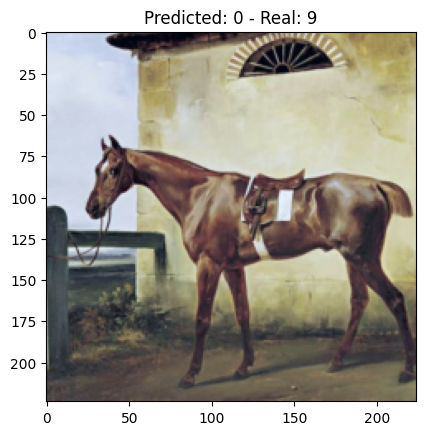

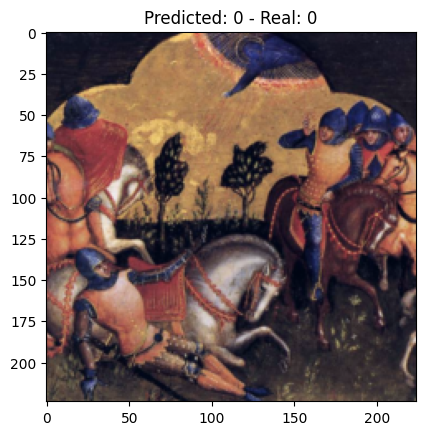

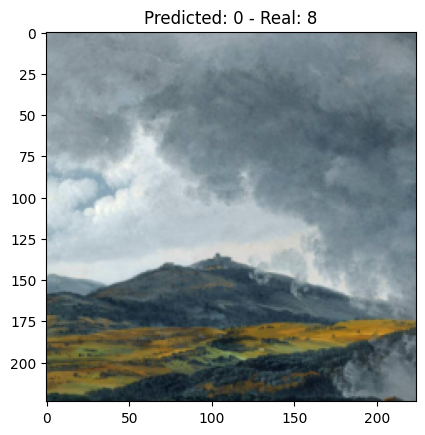

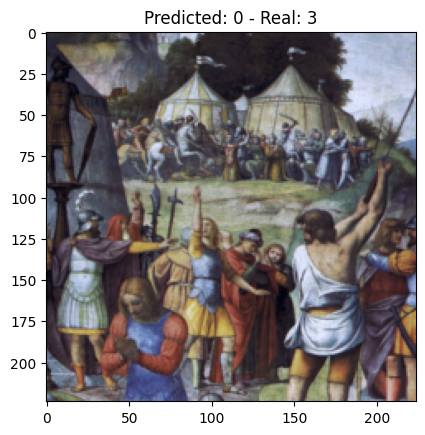

In [ ]:
# TEST
model.eval()
test_dataset = ImageDataset(DataSetEnum.TEST, OutputEnum.TIMEFRAME)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)
with torch.no_grad():
    for batch, (images, labels) in enumerate(test_dataloader):
        for image, label in zip(images, labels):
            pred = model(image.unsqueeze(0))
            rgb_image = image.cpu().permute(1, 2, 0)
            rgb_image = (rgb_image - rgb_image.min()) / (
                rgb_image.max() - rgb_image.min()
            )
            plt.imshow(rgb_image)
            plt.title(
                f"Predicted: {pred.argmax().item()} - Real: {label.argmax().item()}"
            )
            plt.show()
        break


In [ ]:
data = train_dataset[43]
data[1], model.forward(data[0])

(tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0'),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
        grad_fn=<LogSoftmaxBackward0>))